In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter


from investigation_files.flows import (
    AffineConstantFlow, AffineHalfFlow, NormalizingFlowModel, Invertible1x1Conv, ActNorm
    )



%load_ext autoreload
%autoreload 2

### Let's load some toy datasets.

In [2]:
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    Found from https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('./pickled_files/siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ 
        two half-moons taken from an example 
    """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

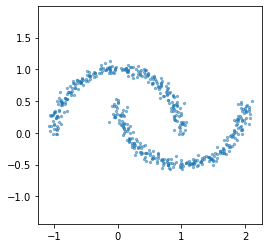

In [5]:
d = DatasetMoons()
# d = DatasetMixture()
# d = DatasetSIGGRAPH()

x = d.sample(512)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

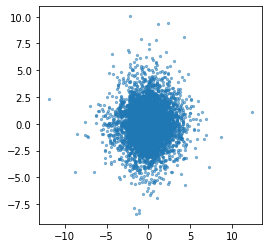

In [6]:
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# Let's sample the prior now. 

z = prior.sample([5000])
plt.figure(figsize=(4,4))
plt.scatter(z[:, 0], z[:, 1], s=5, alpha=0.5)

In [13]:
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=2, shift=False))

model = NormalizingFlowModel(prior, flows)

In [8]:
# Glow paper
flows = [Invertible1x1Conv(dim=2) for i in range(3)]
norms = [ActNorm(dim=2) for _ in flows]
couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

model = NormalizingFlowModel(prior, flows)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5094


In [32]:
model.train()
for k in range(3000):
    x = d.sample(256)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())

350.4656677246094
347.3945617675781
343.2785339355469
340.0124206542969
342.5180969238281
330.38568115234375
328.2838134765625
319.1232604980469
313.95367431640625
312.9958190917969
308.8111572265625
310.16058349609375
305.83123779296875
308.95489501953125
300.1759033203125
293.67498779296875
301.692626953125
293.48602294921875
287.5738525390625
280.6054992675781
282.02532958984375
284.8368835449219
268.0758361816406
265.2823486328125
273.8298034667969
270.9178466796875
268.9164123535156
255.23292541503906
262.0418701171875
260.17919921875


Text(0.5, 1.0, 'z -> x')

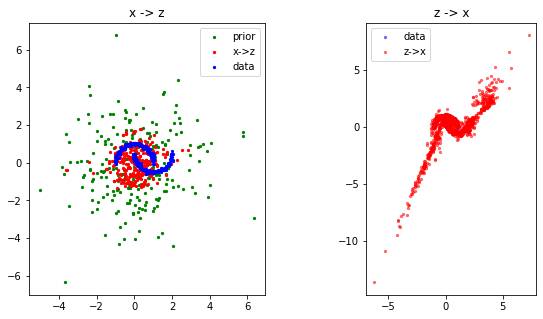

In [31]:
model.eval()

x = d.sample(256)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([256])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')